# Evaluation

In this notebook, the final forecasts, saved in the results folder, are evaluated, based on the naming convention.

In [88]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})


In [89]:
### calculate a given mape for a daily df

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

# functions

def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    actual = pd.Series(actual)
    forecast = pd.Series(forecast)

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    print(ft_wmape_forecast)
    # return a float
    return "WMAPE",ft_wmape_forecast

def mean_absolute_percentage_error(y_true, y_pred):
    return "MAPE", np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return "MAE",mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    rms = mean_squared_error(y_true, y_pred, squared=False)
    return "RMSE", rms

def mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=True)
    return "MSE", mse

def medae(y_true, y_pred):
    return "MEDAE", median_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return "R2",r2_score(y_true, y_pred)

def msle(y_true, y_pred):
    return "MSLE", mean_squared_log_error(y_true, y_pred)

def maape(y_true,y_pred): # https://www.sciencedirect.com/science/article/pii/S0169207016000121
    EPSILON = 1e-10
    return "MAAPE", np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

### from peak challenge
def get_peak_values_from_loadpatterm(loadpattern):
  peakvalues = []
  for i in range (int(len(loadpattern)/24)):
    to_consider = loadpattern[i*24:(i+1)*24]
    peakvalues.append(np.max(to_consider))
  return np.array(peakvalues)

def get_peak_times_from_loadpattern(loadpattern):
    peaktimes = []
    for i in range (int(len(loadpattern)/24)):
        to_consider = loadpattern[i*24:(i+1)*24]
        peaktimes.append(to_consider.tolist().index(np.max(to_consider)))
    to_return = np.array(peaktimes)
    to_return = to_return+1
    return to_return


def shape_score (actual_loadpattern,predicted_loadpattern):
    normed_peaksurroundings_actual = []
    normed_peaksurroundings_pred = []
    for block_index in range (int(len(actual_loadpattern)/24)):
        startindex= block_index*24
        block_actual = actual_loadpattern[startindex:(block_index+1)*24]
        peakvalue_actual = np.max(block_actual)
        peakindex_actual  = np.where(block_actual == peakvalue_actual)[0][0]
        normed_actual = actual_loadpattern/peakvalue_actual

        block_pred = predicted_loadpattern[startindex:(block_index+1)*24]
        peakvalue_pred = np.max(block_pred)
        normed_pred = predicted_loadpattern/peakvalue_pred


        normed_peaksurroundings_actual.extend(normed_actual[startindex + peakindex_actual-2:startindex +peakindex_actual+3])
        normed_peaksurroundings_pred.extend(normed_pred[startindex+peakindex_actual-2: startindex+ peakindex_actual+3])
    normed_peaksurroundings_actual = np.array(normed_peaksurroundings_actual)
    normed_peaksurroundings_pred = np.array(normed_peaksurroundings_pred)
    absolute_errors = abs(normed_peaksurroundings_actual-normed_peaksurroundings_pred)
    return "shape_score", np.sum(absolute_errors)

def peaktime_score(actual_peaktimes, predicted_peaktimes):
    absolute_diffs = abs(actual_peaktimes-predicted_peaktimes)
    total_diffs = 0
    for diff in absolute_diffs:
        if abs(diff)<2:
            total_diffs = total_diffs+diff
        elif abs(diff)<5:
            total_diffs = total_diffs+(diff*2)
        else:
            total_diffs = total_diffs+(10)
    return "peaktime_score", total_diffs


def peak_mape(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_mape", mean_absolute_percentage_error(peakvalues_actual,predictions_at_peaktime)[1]

def peak_rmse(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_rmse", rmse(peakvalues_actual,predictions_at_peaktime)[1]


def peaktime_mae(actual_values, forecasted_values):
  peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
  predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
  return "peaktime_mae", mean_absolute_error(peaktimes_actual,predictions_peaktime)

def percentage_match(peaktimes_actual, predictions_peaktime):
    if len(peaktimes_actual) != len(predictions_peaktime):
        raise ValueError("Arrays must have the same length")

    count_matching = sum(1 for x, y in zip(peaktimes_actual, predictions_peaktime) if x == y)
    total_elements = len(peaktimes_actual)

    percentage = (count_matching / total_elements) * 100
    return percentage

def peaktime_accuracy(actual_values, forecasted_values):
    peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
    predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
    result = percentage_match(peaktimes_actual, predictions_peaktime)

    return "peaktime_accuracy", result

# we also evaluate the metrics for the highest n-decile of true value
def highest_decile_metric(y_true,y_pred,function,decile):
    desired_hits = int(len(y_true)*decile)
    ind_highest = np.argpartition(y_true, -desired_hits)[-desired_hits:]
    top_hits_true = y_true[ind_highest]
    top_hits_pred = y_pred[ind_highest]
    name, res = function(top_hits_true,top_hits_pred)
    return name+"_decile_"+str(decile), res

# evaluation

functions = [mean_absolute_percentage_error,mae,rmse,r2]

def evaluate_metrics(target_df, functions):
    results = {}
    for function in functions:
        name, res = function(target_df["Agg Load"].values, target_df["Predict"].values)
        results.update({name:res})

    return results

## Individual Aggregated vs. directly combined

In [90]:
#methods = ["LSTM","LSTM CEEMDAM"]
methods = ["Random Forest","Random Forest CEEMDAN","XGB","XGB CEEMDAN", "LSTM","LSTM CEEMDAN","Transformer","Transformer CEEMDAN"]
nn_methods = ["LSTM","LSTM CEEMDAN","Transformer"]
''
hh_results = pd.DataFrame()
hp_results = pd.DataFrame()
total_results = pd.DataFrame()

hh_comparison = pd.DataFrame()
hp_comparison = pd.DataFrame()
total_comparison = pd.DataFrame()

for method in methods:
    print(method)
    comb = pd.DataFrame()
    hp_df = pd.read_pickle("./results/HP "+method+" Results.pkl")
    hh_df = pd.read_pickle("./results/HH "+method+" Results.pkl")
    comb_df = pd.read_pickle("./results/Comb "+method+" Results.pkl")
    if method in nn_methods:
        hp_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        hh_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        comb_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        
    # creating df for plotting
    hh_comparison.index = hh_df.index
    hp_comparison.index = hp_df.index
    total_comparison.index = comb_df.index
    hh_comparison[method] = hh_df["Predict"].values
    hp_comparison[method] = hp_df["Predict"].values
    total_comparison[method] = comb_df["Predict"].values
    hh_comparison["Real Load"] = hh_df["Agg Load"].values
    hp_comparison["Real Load"] = hp_df["Agg Load"].values
    total_comparison["Real Load"] = comb_df["Agg Load"].values
    
    
    comb.index = hp_df.index
    comb["Predict"] = hp_df["Predict"] + hh_df["Predict"]
    comb["Agg Load"] = hp_df["Agg Load"] + hh_df["Agg Load"]
    
    hp_results[method] = evaluate_metrics(hp_df,functions)
    hh_results[method] = evaluate_metrics(hh_df,functions)
    
    total_results[method+": Separate"] =  evaluate_metrics(comb,functions)
    total_results[method+": Combined"] =  evaluate_metrics(comb_df,functions)

    
    
    

Random Forest
Random Forest CEEMDAN
XGB
XGB CEEMDAN
LSTM
LSTM CEEMDAN
Transformer
Transformer CEEMDAN


## Rank the results

In [91]:
total_results_rank = total_results.copy()


# Define which metrics should be ranked in ascending order
ascending_metrics = ['MAPE', 'MAE', 'RMSE', 'peak_rmse', 'peaktime_mae']

# Apply ranking row-wise
for metric in total_results.index:
    ascending = metric in ascending_metrics
    total_results_rank.loc[metric] = total_results.loc[metric].rank(method='min', ascending=ascending)


In [92]:
total_results_rank.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/ranks.tex",float_format="%.0f")
total_results_rank

<ipython-input-92-2d3011dcedd2>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  total_results_rank.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/ranks.tex",float_format="%.0f")


,Random Forest: Separate,Random Forest: Combined,Random Forest CEEMDAN: Separate,Random Forest CEEMDAN: Combined,XGB: Separate,XGB: Combined,XGB CEEMDAN: Separate,XGB CEEMDAN: Combined,LSTM: Separate,LSTM: Combined,LSTM CEEMDAN: Separate,LSTM CEEMDAN: Combined,Transformer: Separate,Transformer: Combined,Transformer CEEMDAN: Separate,Transformer CEEMDAN: Combined
MAPE,8.000,9.000,16.000,15.000,6.000,7.000,13.000,14.000,12.000,10.000,5.000,11.000,2.000,1.000,4.000,3.000
MAE,7.000,11.000,15.000,16.000,6.000,10.000,13.000,14.000,12.000,8.000,5.000,9.000,2.000,1.000,4.000,3.000
RMSE,7.000,12.000,15.000,16.000,9.000,10.000,13.000,14.000,11.000,6.000,5.000,8.000,2.000,1.000,4.000,3.000
R2,7.000,12.000,15.000,16.000,9.000,10.000,13.000,14.000,11.000,6.000,5.000,8.000,2.000,1.000,4.000,3.000


<AxesSubplot: ylabel='Average rank'>

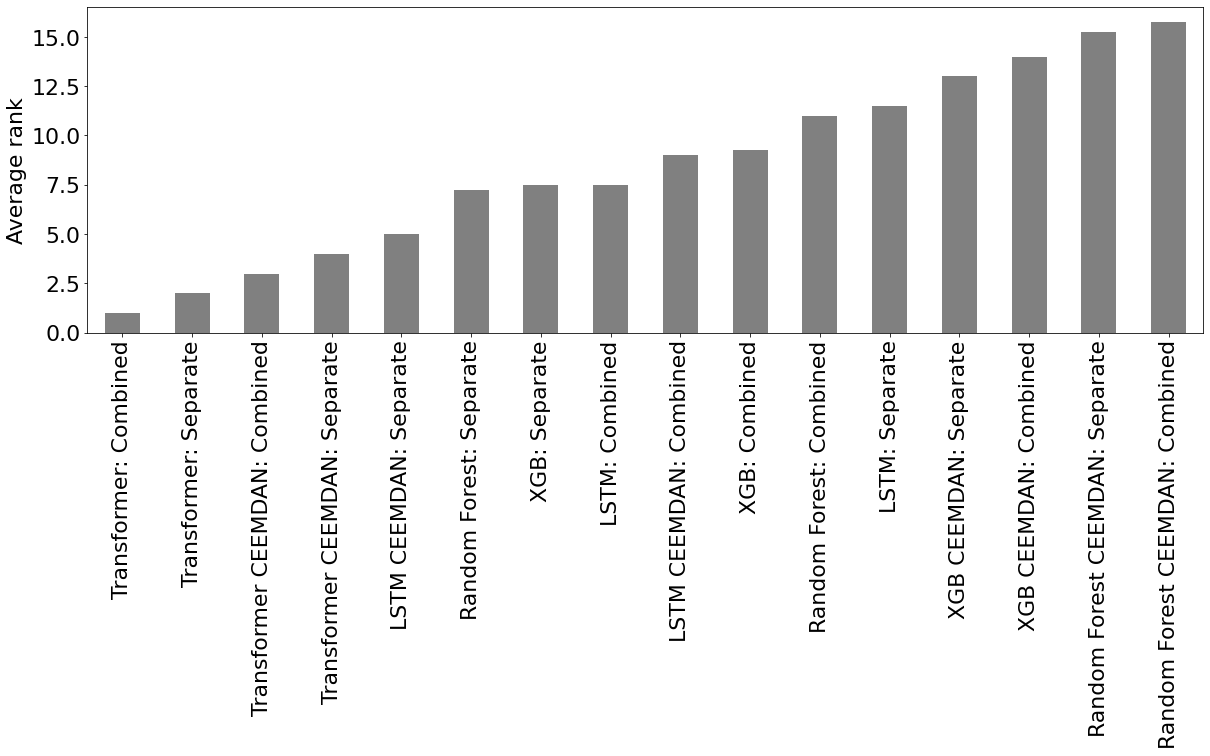

In [93]:
total_results_rank.mean().sort_values().plot.bar(color="grey",figsize=(20,6),ylabel="Average rank")

<AxesSubplot: xlabel='date'>

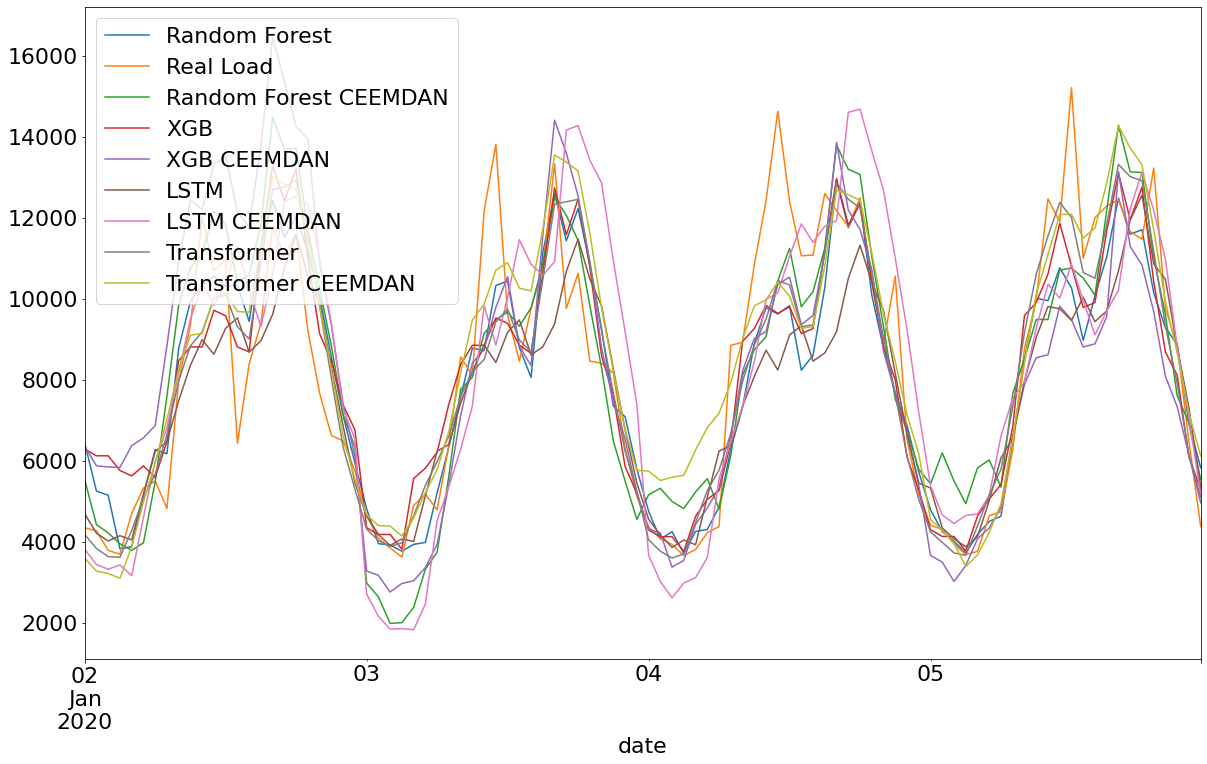

In [94]:
hh_comparison.iloc[24:24*5].plot(figsize=(20,12))

<AxesSubplot: xlabel='date'>

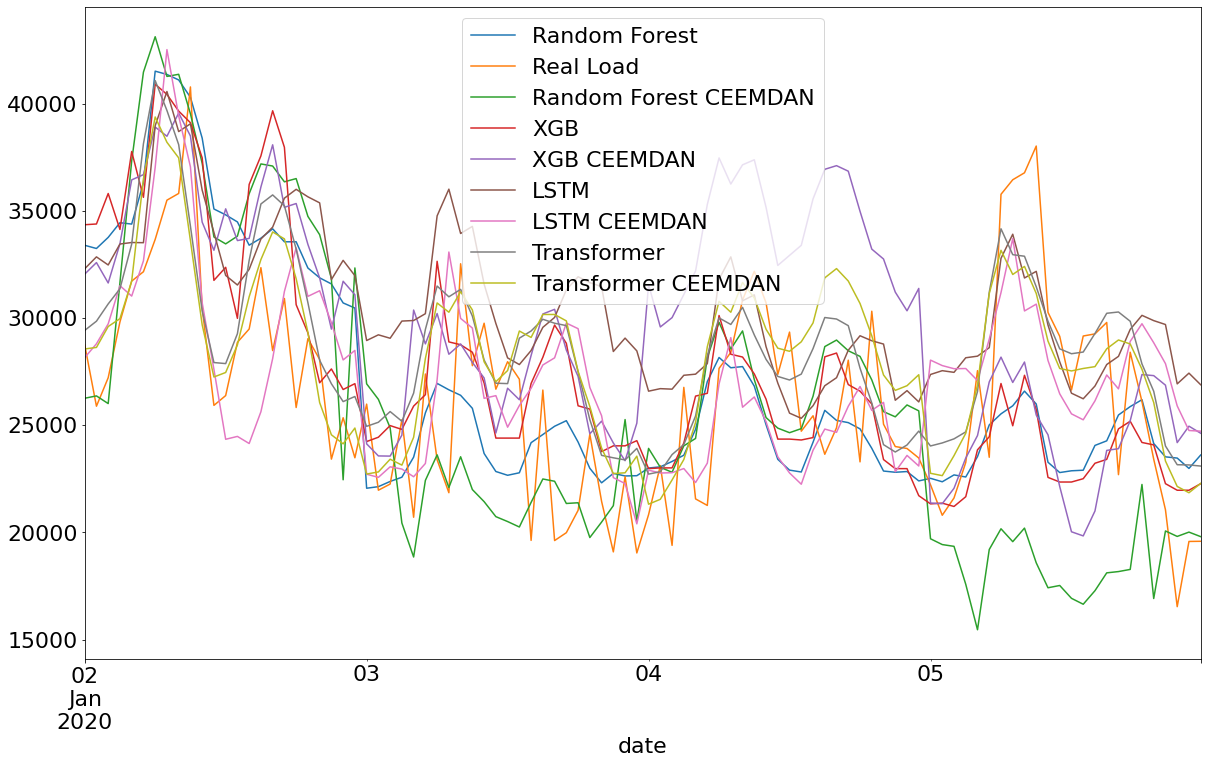

In [95]:
hp_comparison.iloc[24:24*5].plot(figsize=(20,12))

<AxesSubplot: xlabel='date'>

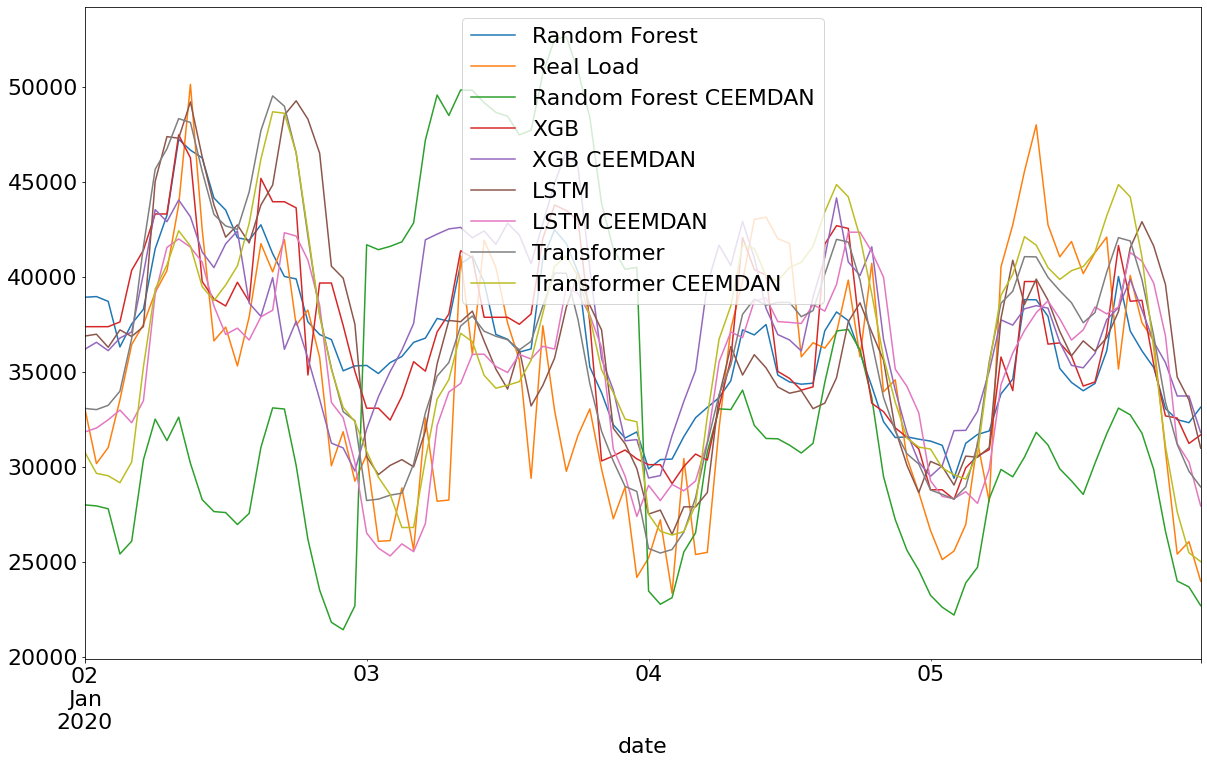

In [96]:
total_comparison.iloc[24:24*5].plot(figsize=(20,12))

In [97]:
hh_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hh_results.tex",float_format="%.2f")
hh_results


<ipython-input-97-bb988d1cf192>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  hh_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hh_results.tex",float_format="%.2f")


,Random Forest,Random Forest CEEMDAN,XGB,XGB CEEMDAN,LSTM,LSTM CEEMDAN,Transformer,Transformer CEEMDAN
MAPE,12.838,15.509,13.113,14.530,14.081,17.116,12.382,15.604
MAE,959.345,1093.852,969.786,1036.190,1041.633,1161.968,921.868,1049.552
RMSE,1362.610,1481.389,1362.025,1421.260,1447.215,1522.470,1301.950,1373.213
R2,0.737,0.690,0.738,0.714,0.704,0.672,0.760,0.733


<AxesSubplot: title={'center': 'RMSE'}>

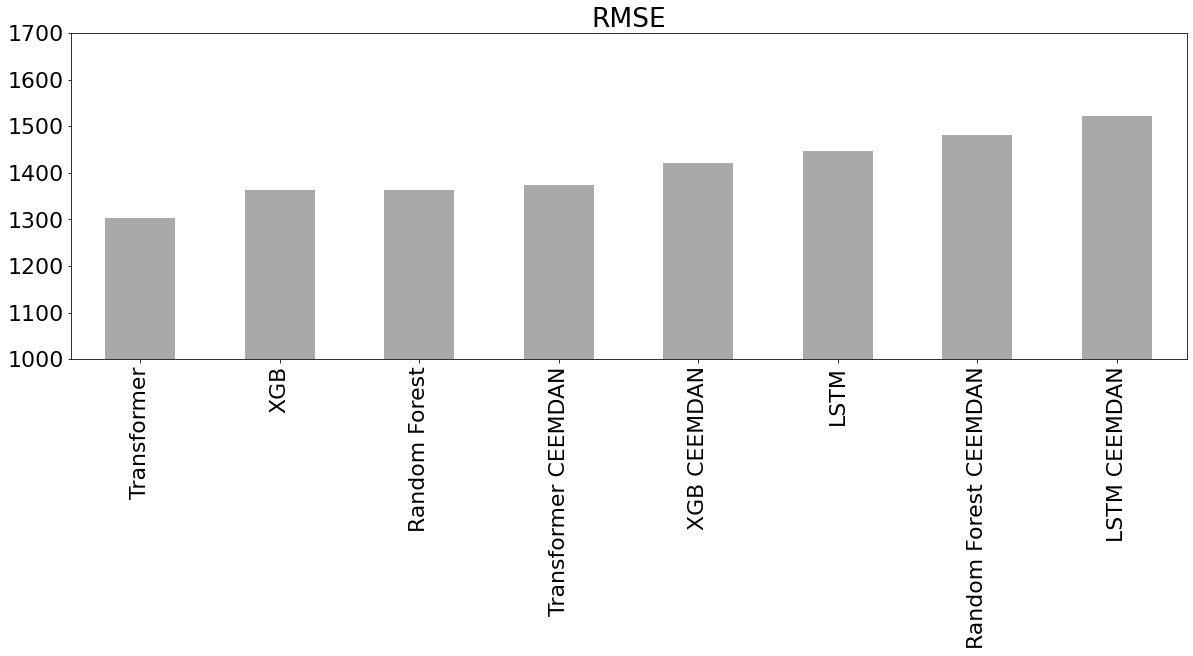

In [98]:
hh_results.T["RMSE"].sort_values().plot.bar(title="RMSE",figsize=(20,6),ylim=(1000,1700),color="darkgrey")

In [99]:
#hh_results.T["peaktime_mae"].sort_values().plot.bar(title="Peaktime MAE",color="navy")

In [100]:
hp_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hp_results.tex",float_format="%.2f")

hp_results

<ipython-input-100-a806693777db>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  hp_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hp_results.tex",float_format="%.2f")


,Random Forest,Random Forest CEEMDAN,XGB,XGB CEEMDAN,LSTM,LSTM CEEMDAN,Transformer,Transformer CEEMDAN
MAPE,52.196,97.539,49.166,70.061,70.505,49.317,34.116,47.931
MAE,2054.399,2985.404,2064.439,2617.097,2240.222,1860.326,1652.116,1690.770
RMSE,2756.476,3897.605,2817.449,3458.964,2908.374,2482.393,2282.134,2226.140
R2,0.882,0.765,0.877,0.815,0.869,0.904,0.919,0.923


<AxesSubplot: title={'center': 'RMSE'}>

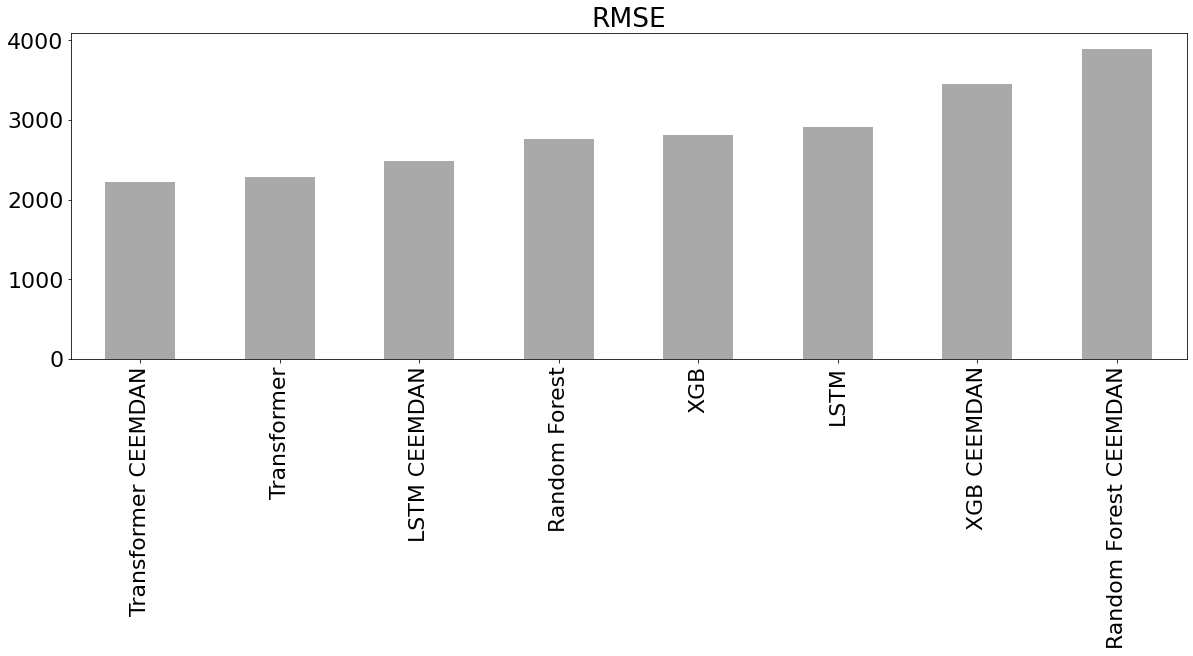

In [101]:
hp_results.T["RMSE"].sort_values().plot.bar(title="RMSE",figsize=(20,6),color="darkgrey")

In [102]:
#hp_results.T["peaktime_mae"].sort_values().plot.bar(title="Peaktime MAE",color="navy")

In [103]:
total_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/total_results.tex",float_format="%.2f")
total_results.T

<ipython-input-103-42f0b5274218>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  total_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/total_results.tex",float_format="%.2f")


,MAPE,MAE,RMSE,R2
Random Forest: Separate,16.794,2377.941,3137.000,0.874
Random Forest: Combined,17.238,2466.569,3269.302,0.863
Random Forest CEEMDAN: Separate,25.396,3274.447,4247.913,0.768
Random Forest CEEMDAN: Combined,22.941,3277.455,4478.732,0.742
XGB: Separate,16.477,2375.881,3168.893,0.871
XGB: Combined,16.579,2432.934,3256.328,0.864
XGB CEEMDAN: Separate,20.802,2913.927,3827.778,0.812
XGB CEEMDAN: Combined,21.312,3056.006,4097.767,0.784
LSTM: Separate,18.764,2525.473,3265.964,0.863
LSTM: Combined,17.386,2409.674,3117.768,0.875


<AxesSubplot: title={'center': 'RMSE'}>

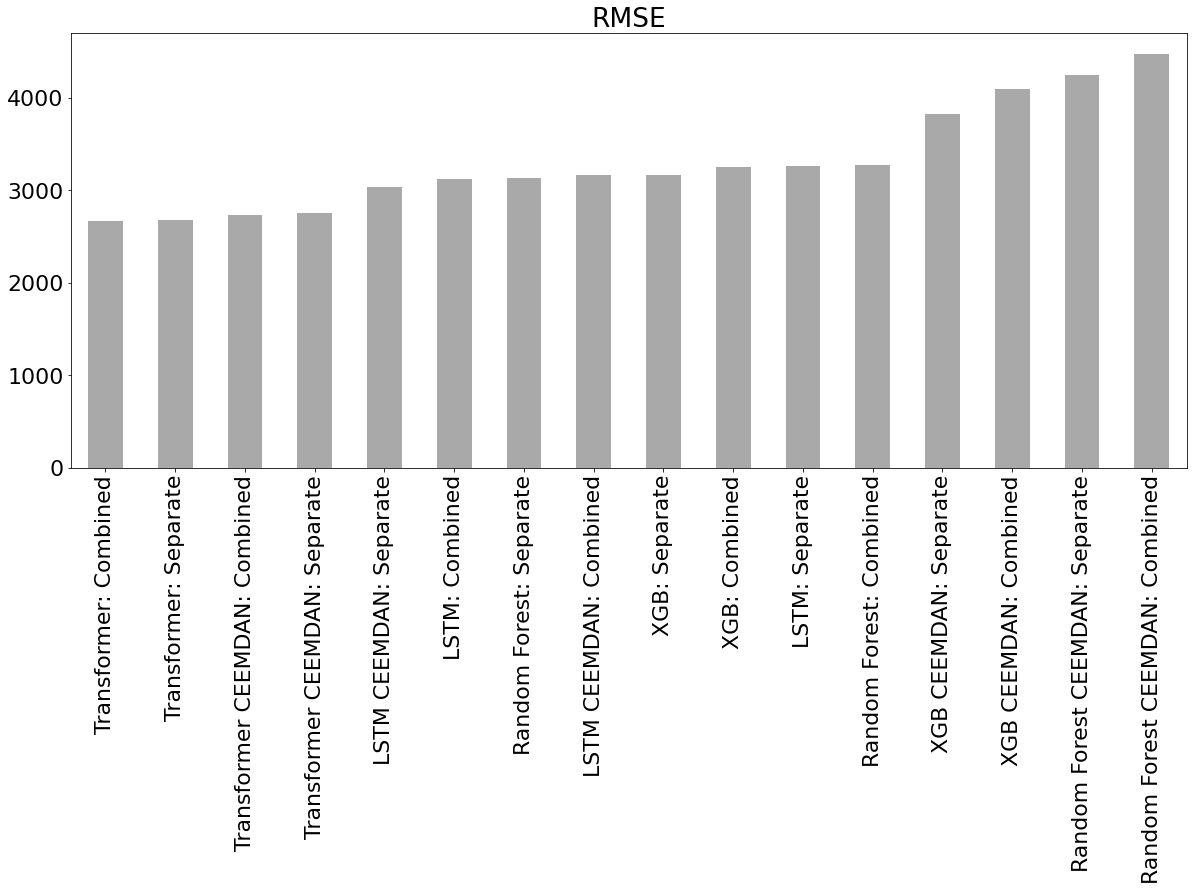

In [104]:
total_results.T["RMSE"].sort_values().plot.bar(title="RMSE",figsize=(20,8),color="darkgrey")

In [105]:
total_results.T

,MAPE,MAE,RMSE,R2
Random Forest: Separate,16.794,2377.941,3137.000,0.874
Random Forest: Combined,17.238,2466.569,3269.302,0.863
Random Forest CEEMDAN: Separate,25.396,3274.447,4247.913,0.768
Random Forest CEEMDAN: Combined,22.941,3277.455,4478.732,0.742
XGB: Separate,16.477,2375.881,3168.893,0.871
XGB: Combined,16.579,2432.934,3256.328,0.864
XGB CEEMDAN: Separate,20.802,2913.927,3827.778,0.812
XGB CEEMDAN: Combined,21.312,3056.006,4097.767,0.784
LSTM: Separate,18.764,2525.473,3265.964,0.863
LSTM: Combined,17.386,2409.674,3117.768,0.875


In [106]:
'''methods
int(total_results.shape[1]/2)
total_results.T.iloc[0]
total_results["Random Forest CEEMDAN: predicted then summed"]["RMSE"]'''

'methods\nint(total_results.shape[1]/2)\ntotal_results.T.iloc[0]\ntotal_results["Random Forest CEEMDAN: predicted then summed"]["RMSE"]'

In [107]:
# comparing effects of individual aggregation

compare_res = []
for method in methods:
    rmse_individual = total_results[method+": Separate"]["RMSE"]
    rmse_combined =  total_results[method+": Combined"]["RMSE"]
    improvement = rmse_individual-rmse_combined
    compare_res.append({"method":method,"RMSE change":improvement,"Separate":rmse_individual,"Combined":rmse_combined})
    

<AxesSubplot: ylabel='RMSE'>

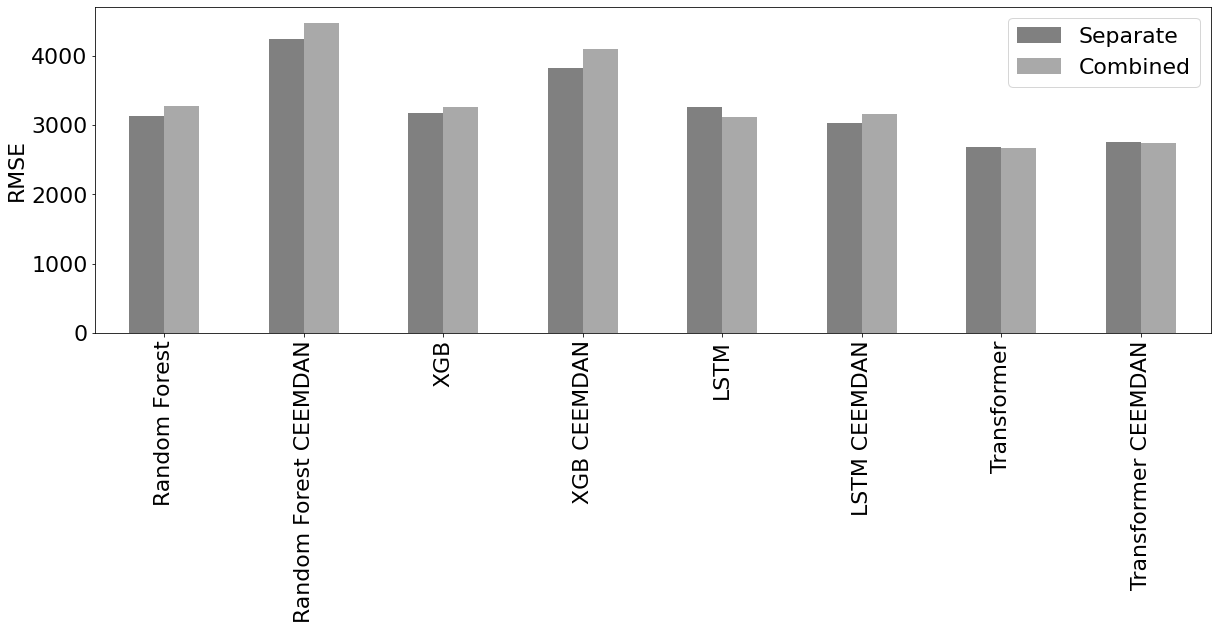

In [108]:
plt.rcParams.update({'font.size': 22})

df_change = pd.DataFrame(compare_res)
df_change.set_index("method")[["Separate","Combined"]].plot.bar(figsize=(20,6),color=["grey","darkgrey"],ylabel="RMSE",xlabel="")



In [61]:
df_change

,method,RMSE change,Separate,Combined
0,Random Forest,-132.302,3137.000,3269.302
1,Random Forest CEEMDAN,-230.820,4247.913,4478.732
2,XGB,-87.435,3168.893,3256.328
3,XGB CEEMDAN,-269.989,3827.778,4097.767
4,LSTM,205.952,3247.752,3041.799
5,LSTM CEEMDAN,-137.321,3029.791,3167.112
6,Transformer,17.090,2681.627,2664.537
7,Transformer CEEMDAN,17.814,2754.216,2736.402


## Monthly RMSE performance

In [299]:
hp_monthly_results = pd.DataFrame()
hh_monthly_results = pd.DataFrame()
comb_monthly_results = pd.DataFrame()


for method in methods:
    print(method)
    comb = pd.DataFrame()
    hp_df = pd.read_pickle("./results/HP "+method+" Results.pkl")
    hh_df = pd.read_pickle("./results/HH "+method+" Results.pkl")
    comb_df = pd.read_pickle("./results/Comb "+method+" Results.pkl")
    if method in nn_methods:
        hp_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        hh_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        comb_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
    
    hp_df["RMSE"] = hp_df.apply(lambda x: rmse([x["Agg Load"]], [x["Predict"]])[1],axis=1)
    grouped_df = hp_df.groupby(hp_df.index.month).mean()
    hp_monthly_results.index = grouped_df.index
    hp_monthly_results[method] = grouped_df["RMSE"]
    
    hh_df["RMSE"] = hh_df.apply(lambda x: rmse([x["Agg Load"]], [x["Predict"]])[1],axis=1)
    grouped_df = hh_df.groupby(hh_df.index.month).mean()
    hh_monthly_results.index = grouped_df.index
    hh_monthly_results[method] = grouped_df["RMSE"]
    
    comb_df["RMSE"] = comb_df.apply(lambda x: rmse([x["Agg Load"]], [x["Predict"]])[1],axis=1)
    grouped_df = comb_df.groupby(comb_df.index.month).mean()
    comb_monthly_results.index = grouped_df.index
    comb_monthly_results[method] = grouped_df["RMSE"]

Random Forest
RF CEEMDAN
XGB
XGB CEEMDAN
LSTM
LSTM CEEMDAN
Transformer
Transformer CEEMDAN


<AxesSubplot: >

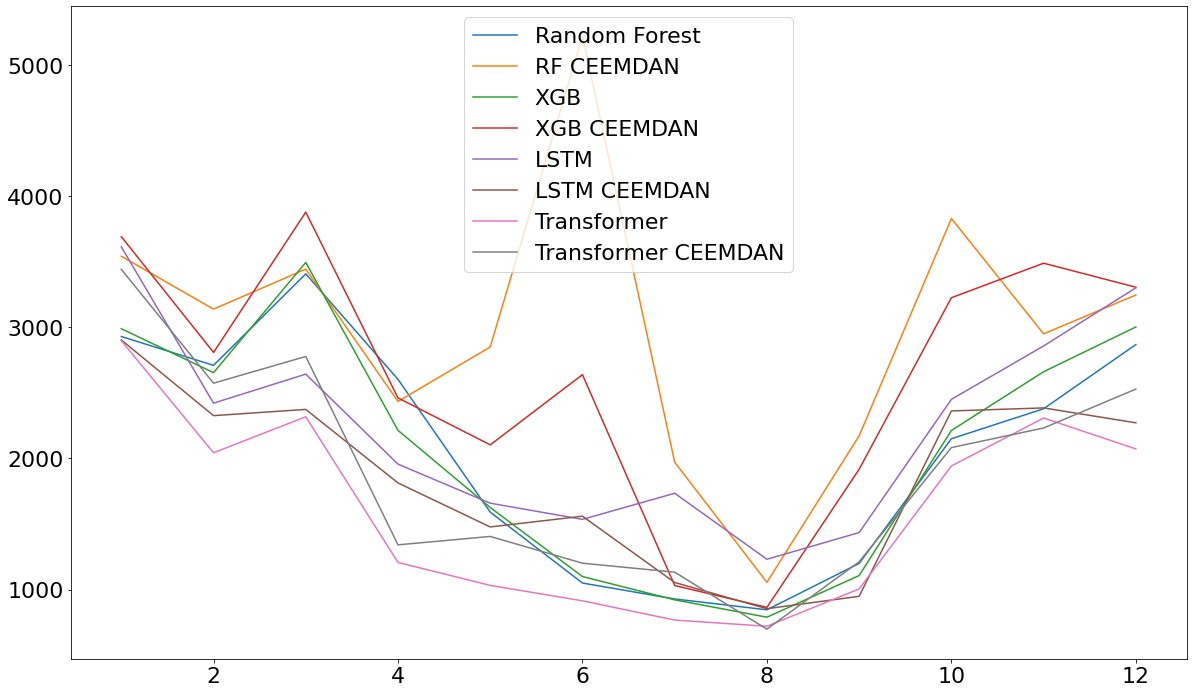

In [300]:
hp_monthly_results.plot(figsize=(20,12))

<AxesSubplot: >

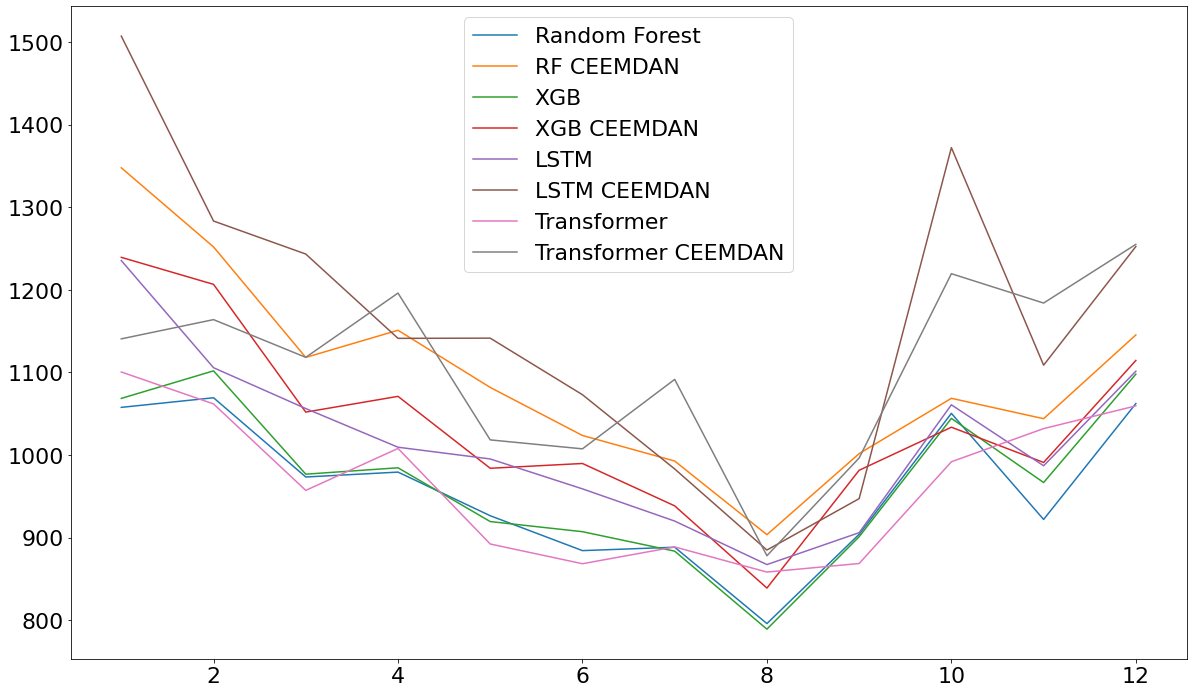

In [301]:
hh_monthly_results.plot(figsize=(20,12))

<AxesSubplot: >

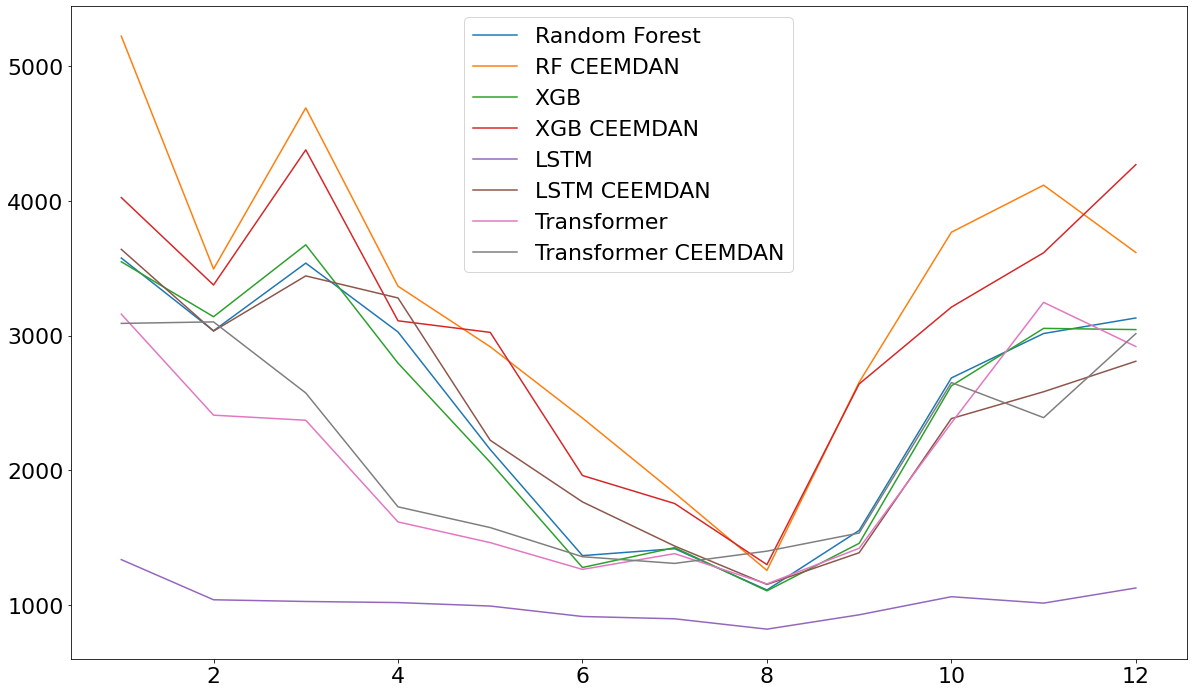

In [302]:
comb_monthly_results.plot(figsize=(20,12))